In [2]:
from IPython.display import Image

# 6장 모델 평가와 하이퍼 파라미터 튜닝의 모범 사례

- 머신 러닝 모델 성능 평가하기
- 머신 러닝 알고리즘에서 일반적으로 발생하는 문제 분석하기
- 머신러닝 모델 세부 튜닝하기
- 여러 가지 성능 지표를 사용하여 모델의 예측 성능 평가하기

## 6.1 파이프라인을 사용한 효율적인 워크플로

- 사이킷런의 Pipeline 클래스를 다룬다.

### 6.1.1 위스콘신 유방암 데이터셋

- 569개의 데이터
- 고유 ID번호 진단결과
- 3~32번째 : 세포 핵의 디지털 이미지에서 계산된 30개의 실수 값 특성


In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.shape

(569, 32)

30개의 특성을 X에 할당한다.  
LabelEncoder 객체를 이용해 클래스 레이블을 원본 문자열 표현에서 정수로 변환한다.

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [6]:
le.transform(['M', 'B'])

array([1, 0])

훈련 데이터셋(80%), 테스트 데이터셋(20%)으로 분리한다.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

### 6.1.2 파이프라인으로 변환기와 추정기 연결

- 최적의 성능을 위해 입력 특성이 같은 스케일을 가져야한다.
- 위스콘신 유방암 데이터셋의 특성은 다양한 스케일로 측정되었기 때문에 로지스틱 회귀 같은 선형 분류기에 주입하기 전에 특성을 표준화해야한다.
- 주성분 분석을 통해 30차원에서 2차원 부분 공간으로 데이터를 압축한다고 가정한다.

- 훈련 데이터셋과 테스트 데이터셋을 각각 학습하고 변환하는 단계를 구성하는 대신   
    StandardScaler, PCA, LogisticRegerssion 객체를 하나의 파이프라인으로 연결할 수 있다.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


make_pipeline 함수는 여러 개의 사이킷런 변환기와 그 뒤에 fit 메서드와 predict 메서드를 구현한 사이킷 런의 Pipeline 클래스 객체를 생성하여 반환한다.  
위의 예제에서는 StandardScaler, PCA 두 개의 변환기와 LogisticRegerssion 추정기를 입력으로 넣었다.  


In [9]:
Image(url='https://git.io/JtsTr', width=500) 

In [10]:
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

## 6.2 k-겹 교차 검증을 사용한 모델 성능 평가

머신 러닝 모델을 구축하는 핵심 단계 중 하나는 처음 본 데이터에 대한 모델 성능을 추정하는 것이다.  
모델이 너무 간단하면 **과소적합**이 문제가 되고, 너무 복잡하면 **과대적합**이 문제가된다.  
적절한 편향-분산 트레이드오프를 찾으려면 모델을 주의 깊게 평가해야 한다.  
이 절에서는 보편적인 교차 검증 기법인 **홀드아웃 교차 검증**과 **k-겹 교차검증**을 배운다.  

### 6.2.1 홀드아웃 방법

- 초기 데이터셋을 별도의 훈련 데이터셋과 테스트 데이터셋으로 나눈다.
- 전자는 모델 훈련에 사용하고 후자는 일반화 성능을 추정하는 데 사용한다.
- 일반적인 머신 러닝 애플리케이션에서는 처음 본 데이터에서 예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교해야 한다.(**모델 선택**)
- 모델 선택이란 이름은 주어진 분류 문제에서 튜닝할 파라미터의 최적 값을 선택해야하 하는 것을 의미한다.
- 같은 테스트 데이터셋을 반복해서 재사용하면 훈련 데이터셋의 일부가 되는 셈이고 결국 모델은 과대적합될 것이다.
----
- 모델 선택에 홀드아웃 방법을 사용하는 가장 좋은 방법은 데이터를 훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋 세 개의 부분으로 나누는 것이다.
- 훈련 데이터셋은 여러 가지 모델을 훈련 하는 데 사용한다.
- 검증 데이터셋에 대한 성능은 모델 선택에 사용한다.
- 훈련과 모델 선택 단계에서 모델이 만나지 못한 테스트 데이터셋을 분리했기 때문에 새로운 데이터에 대한 일반화 능력을 덜 편향되게 추정할 수 있는 장점이 있다.


In [11]:
Image(url='https://git.io/JtsTo', width=500) 

홀드아웃 방법은 훈련 데이터를 훈련 데이터셋과 검증 데이터셋으로 나누는 방법에 따라 성능 추정이 민감할 수 있다는 것이 단점이다. 

### 6.2.2 k-겹 교차 검증

- k-겹 교차 검증에서는 중복을 허용하지 않고 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눈다.
- k-1개의 폴드로 모델을 훈련하고 나머지 하나의 폴드로 성능을 평가한다.
- k번 반복하여 k개의 모델과 성능 추정을 얻는다.
   
홀드아웃 방법에 비해 훈련 데이터셋의 분할에 덜 민감한 성능 추정을 얻을 수 있다.
- 일반적으로 모델 튜닝에 k-겹 교차 검증을 사용한다.
- 테스트 데이터셋에서 모델의 성능을 평가할 때 만족할 만한 일반화 성능을 내는 최적의 하이퍼파라미터 값을 찾기 위해 사용한다.
- 만족스러운 하이퍼 ㅎ파라미터 값을 찾은 후에는 전체 훈련 데이터셋을 사용하여 모델을 다시 훈련한다.
- 독립적인 테스트 데이터셋을 사용하여 최종 성능 추정을 한다. 
- 이 과정을 거치는 이유는 훈련 샘플이 많을 수록 학습 알고리즘이 더 정확하고 안정적인 모델을 만들기 때문이다.
---
k-겹 교차 검증이 중복을 허용하지 않는 리샘플링 기법이기 때문에 모든 샘플 포인트가 훈련하는 동안 검증에 딱 한 번 사용되는 장점이 있다.  
이로 인해 홀드아웃 방법보다 모델 성능 추정에 분산이 낮다. 

In [12]:
Image(url='https://git.io/JtsT6', width=500) 

k = 10일 때 k-겹 교차 검증의 개념이다.  
훈련 데이터는 열 개의 폴드로 나누어지고 열 번의 반복 동안 아홉 개의 폴드는 훈련에, 한 개의 폴드는 모델 평가에 사용된다.  
각 폴드의 추정 성능 $E_i$(예를 들어 분류 정확도 또는 오차)를 사용하여 모델의 평균 성능 $E$를 계산한다.

- 론 코하비 : k=10 이 가장 뛰어난 편향-분산 트레이드오프를 가진다고 제안했다.
- 비교적 작은 훈련 데이터셋으로 작업한다면 폴드 개수를 늘리는 것이 좋다.
- k 값이 증가하면 더 많은 훈련 데이터가 각 반복에 사용되고 모델 성능을 평균하여 일반화 성능을 추정할 때 더 낮은 편향을 만든다.
- k 값이 아주 크면 교차 검증 알고리즘의 실행 시간이 늘어나고 분산이 높은 추정을 만든다. (훈련 폴드가 비슷해지기 때문)
- 즉, 대규모 데이터셋으로 작업할 때는 k = 5와 같은 작은 k 값을 사용해도 모델의 평균 성능을 정확하게 추정할 수 있다.
- LOOCV 방법 : k=n 하나의 훈련 샘플이 각 반복에서 테스트로 사용된다. (데이터셋이 아주 작을때 권장되는 방법)



기본 k-겹 교차 검증 방법보다 좀 더 향상된 방법은 계층적 k-겹 교차 검증이다.  
좀 더 나은 편향과 분산 추정을 만든다. (특히 론 코하비가 보인 것처럼 클래스 비율이 동등하지 않을 때)  
각 폴드에서 클래스 비율이 전체 훈련 데이터 셋에 있는 클래스 비율을 대표하도록 유지한다.  
StratifiedKFold 클래스의 shuffle 매개변수를 True로 지정하면 폴드를 나누기 전에 샘플을 섞는다. 기본 값은 False

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956

CV 정확도: 0.950 +/- 0.014


먼저  sklearn.model_selection 모듈에 있는 StratifiedKFold 클래스를 훈련 데이터셋의 y_train 클래스 레이블을 전달하여 초기화 한다.  
n_splits 매개변수로 폴드 개수를 지정한다.  
kfold 반복자를 사용하여 k개의 폴드를 반복하여 얻은 train의 인덱스를 로지스틱 회귀 파이프라인을 훈련하는 데 사용할 수 있다.  
pipe_lr을 사용하므로 각 반복에서 샘플의 스케일이 적절하게 조정된다.  
그 다음 텍스트 인덱스를 사용하여 모델의 정확도 점수를 계산한다.  
이 점수를 리스트에 모아서 추정한 정확도의 평균과 표준 편차를 계산한다.  
  
  위 코드가 k-겹 교차 검증의 작동 방법을 설명하는 데 유용하지만, 사이킷런은 k-겹 교차 검증 함수를 제공한다.  
  좀 더 간단하게 계층별 k-겹 교차 검증을 사용하여 모델을 평가할 수 있다.

In [14]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


scoring 매개변수에 지정한 평가 지표마다 훈련 점수와 테스트 점수를 반환합니다.  
반환된 딕셔너리에서 훈련 점수와 테스트 점수를 추출하려면 'train_XXXX', 'test_XXXX'형식의 키를 사용하면 된다.  
위 코드는 아래와 같이 바꾸어 쓸 수 있다.

In [15]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr, 
                        X=X_train, 
                        y=y_train, 
                        scoring=['accuracy'], 
                        cv=10, 
                        n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), 
                                 np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


cross_val_predict 함수는 cross_val_score와 비슷한 인터페이스를 제공하지만 훈련 데이터셋의 각 샘플이 테스트 폴드가 되었을 때 만들어진 예측을 반환합니다.   
따라서 cross_val_predict 함수의 결과를 사용하여 모델의 성능(예를 들어 정확도)을 계산하면 cross_val_score 함수의 결과와 다르며 바람직한 일반화 성능 추정이 아닙니다.   
cross_val_predict 함수는 훈련 데이터셋에 대한 예측 결과를 시각화하거나 7장에서 소개하는 스태킹(Stacking) 앙상블(Ensemble) 방법처럼 다른 모델에 주입할 훈련 데이터를 만들기 위해 사용할 수 있습니다.

---
이해 내용
- 테스트 폴드일 때 만들어진 예측을 반환한다.
- 함수의 결과를 가지고 성능을 계산하면 위의 내용과는 다르다.
- 보통 cross_val_predict 함수는 예측 결과를 시각화하거나 다른 모델에 주입할 훈련 데이터를 새로 만들기 위해 사용한다.

In [16]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train, 
                          y=y_train,
                          cv=10, 
                          n_jobs=-1)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

method 매개변수에 반환될 값을 계산하기 위한 모델의 메서드를 지정할 수 있다.  
예를 들어 method= 'predict_proba'로 지정하면 예측 확률을 반환한다.  
'predict', 'predict_proba', 'predict_log_proba', 'decision_function' 등이 가능하며 기본값은 'predict'이다.

In [17]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train, 
                          y=y_train,
                          cv=10, 
                          method='predict_proba', 
                          n_jobs=-1)
preds[:10]

array([[9.93982352e-01, 6.01764759e-03],
       [7.64328337e-01, 2.35671663e-01],
       [9.72683946e-01, 2.73160539e-02],
       [8.41658121e-01, 1.58341879e-01],
       [9.97144940e-01, 2.85506043e-03],
       [9.99803660e-01, 1.96339882e-04],
       [9.99324159e-01, 6.75840609e-04],
       [2.12145074e-06, 9.99997879e-01],
       [1.28668437e-01, 8.71331563e-01],
       [7.76260670e-04, 9.99223739e-01]])

n_jobs = -1로 설정하면 컴퓨터에 설치된 모든 CPU 코어를 사용하여 병렬처리 한다.

## 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

### 6.3.1 학습 곡선으로 편향과 분산 문제 분석
- 모델의 자유도나 모델 파라미터가 너무 많으면 모델이 훈련 데이터에 과대적합되고 처음 본 데이터에 잘 일반화되지 못하는 경향이 있다.
- 보통 훈련 샘플을 더 모으면 과대적합을 줄이는 데 도움이 된다.
- 하지만 실전에서는 데이터를 더 모으는 것이 매우 비싸거나 그냥 불가능할 때도 많다.
- 모델의 훈련 정확도와 검증 정확도를 훈련 데이터셋의 크기 함수로 그래프를 그려서 모델에 높은 분산의 문제가 있는지 높은 편향의 문제가 있는지 쉽게 감지할 수 있다.


In [18]:
Image(url='https://git.io/JtsTi', width=600) 

1. 왼쪽 위 그래프
    - 편향이 높다.
    - 훈련 정확도와 교차 검증 정확도가 모두 낮다.
    - 훈련 데이터에 과소적합 되었다.
    - 이 문제를 해결하는 일반적인 방법은 모델의 파라미터 개수를 늘리는 것이다.
    - 예를 들어 추가적인 특성을 수집하거나 만든다. 혹은 서포트 벡터 머신이나 로지스틱 회귀 분류기에서 규제 강도를 줄인다.
2. 오른쪽 위 그래프
    - 분산이 높다.
    - 훈련 정확도와 교차 검증 정확도 사이에 큰 차이가 있다.
    - 과대적합 문제를 해결하려면 더 많은 훈련 데이터를 모으거나 모델 복잡도를 낮추거나 규제를 증가시킬 수 있다.
    - 규제가 없는 모델에서는 특성 선택이나 특성 추출을 통해 특성의 개수를 줄여 과대적합을 감소 시킬 수 있다.
    - 더 많은 데이터를 수집하는 것이 보통 과대적합의 가능성을 줄이지만 항상 도움이 되는 것은 아니다.
    - 예를 들어 훈련 데이터에 잡음이 아주 많거나 모델이 이미 거의 최적화가 된 경우이다.


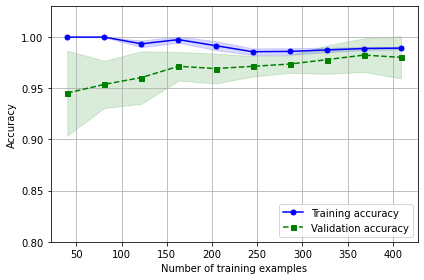

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

LogisticRegerssion 클래스의 객체를 만들 때 max_iter=10000 매개변수 값을 전달했다.(기본값은 1000)  
이는 큰 규제 매개변수 값이나 작은 데이터셋 크기에서 발생할 수 있는 술며 문제를 피하기 위해서이다. 

learning_curve 함수의 train_sizes 매개변수를 통해 학습 곡선을 생성하는 데 사용할 훈련 샘플의 개수나 비율을 지정할 수 있다.  
기본적으로 learning_curve 함수는 계층별 k-겹 교차 검증을 사용하여 분류기의 교차 검증 정확도를 계산한다.  
cv 매개변수를 통해 k 값을 10으로 지정했기 때문에 계층별 10-겹 교차 검증을 사용한다.

위의 학습 곡선 그래프에서 볼 수 있듯이 모델 훈련에 250개의 샘플 이상을 사용할 때 훈련과 검증 데이터셋에서 잘 작동한다.  
훈련 데이터셋이 250개의 샘플보다 줄어들면 훈련 정확도가 증가하면서 둘의 차이는 넓어진다.  
이는 과대적합이 증가한다는 이야기이다.

### 6.3.2 검증 곡선으로 과대적합과 과소적합 조사

- 검증 곡선은 과대적합과 과소적합 문제를 해결하여 모델 성능을 높일 수 있는 유용한 도구이다.
- 검증 곡선은 학습 곡선과 관련이 있지만 샘플 크기의 함수로 훈련 정확도와 테스트 정확도를 그리는 대신 모델 파라미터 값의 함수로 그린다.
- 예를 들어 로지스틱 회귀에 있는 규제 매개변수 c이다.

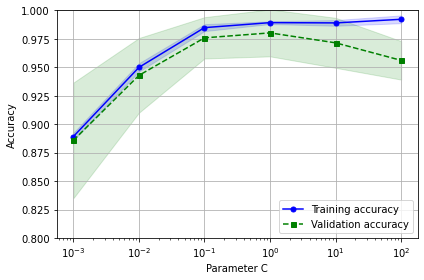

In [20]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

매개변수 c에 대한 검증 곡선 그래프를 얻게 된다.  
learning_curve 함수와 비슷하게 validation_curve 함수는 기본적으로 계층별 k-겹 교차 검증을 사용하여 모델의 성능을 추정한다.  
validation_curve 함수 안에서 평가하기 원하는 매개변수를 지정한다.  
param_range 매개변수에는 값 범위를 지정한다.  

---
C값이 바뀜에 따라 정확도 차이가 미묘하지만 규제 강도를 높이면 모델이 데이터에 조금 과소적합되는 것을 볼 수 있다.  
위 경우 적절한 C 값은 0.01과 0.1 사이이다.

## 6.4 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

- 머신 러닝에는 두 종류의 파라미터가 있다.
    - 훈련 데이터에서 학습되는 파라미터 (로지스틱 회귀의 가중치)
    - 별도로 최적화되는 학습 알고리즘의 파라미터 
    - 즉, 모델의 튜닝 파라미터, 하이퍼파라미터 (로지스틱 회귀의 규제 매개변수나 결정 트리의 깊이 매개변수)

### 6.4.1 그리드 서치를 사용한 하이퍼파라미터 튜닝

그리드 서치를 사용하는 방법은 간단하다. 리스트로 지정된 여러 가지 하이퍼파라미터 값 전체를 모두 조사한다.  
이 리스트에 있는 값의 모든 조합에 대해 모델 성능을 평가하여 최적의 조합을 찾는다.  


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


- sklearn.model_selection 모듈에 있는 GridSearchCV 클래스의 객체를 만들고 서포트 벡터 머신을 위한 파이프라인을 훈련하고 튜닝한다.  
- GridSearchCV 클래스의 param_grid에 튜닝하려는 매개변수를 딕셔너리의 리스트로 지정한다.  
- 선형 SVM의 경우 규제 매개변수 C만 튜닝한다. || RBF 커널 SVM에서는 svc__C와 svc__gamma 매개변수를 튜닝한다.
---
훈련 데이터셋을 사용하여 그리드 서치를 수행한 후 최상의 모델 점수는 best_score_ 속성에서 얻고 이 모델의 매개변수는 best_params_ 속성에서 확인할 수 있다.  

독립적인 테스트 데이터셋을 사용하여 최고 모델의 성능을 추정한다.


In [22]:
clf = gs.best_estimator_

# refit=True로 지정했기 때문에 다시 fit() 메서드를 호출할 필요가 없습니다.
# clf.fit(X_train, y_train)

print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


GridSearchCV 클래스와 cross_validate 함수에서 return_train_score 매개변수를 True로 지정하면 훈련 폴드에 대한 점수를 계산하여 반환한다.  
훈련 데이터셋에 대한 점수를 보고 과대적합 과소적합에 대한 정보를 얻을 수 있지만 실행 시간이 오래 걸릴 수 있다.  
param_range에 여덟 개의 값이 지정되어 있기 때문에 SVC 모델은 'linear' 커널에 대해 여덟 번, 'rbf' 커널에 대해 64번의 교차 검증이 수행된다.  
따라서 훈련 폴드마다 반환되는 점수는 총 72개이다.  
이 값은 cv_results_ 딕셔너리 속성에 split{폴드번호}_train_score와 같은 키에 저장되어 있다. (첫 번째 폴드의 점수 : 'split0_train_score')

In [23]:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  return_train_score=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

In [24]:
gs.cv_results_['split0_train_score']

array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [25]:
# 전체 훈련의 평균 값
gs.cv_results_['mean_train_score']

array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [26]:
# 첫 번째 폴드에 대한 테스트 점수
gs.cv_results_['split0_test_score']

array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

GridSearchCV 클래스의 객체에서도 최종 모델의 score, predict, transform 메서드를 바로 호출할 수 있다. 

In [27]:
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))

테스트 정확도: 0.974


매개변수 탐색 범위가 넓거나 규제 매개변수 C처럼 연속적인 값을 탐색해야 하는 경우에 RandomizedSearchCV가 더 효율적이다.  
이 클래스는 n_iter 매개변수로 탐색 횟수를 조정할 수 있어서 컴퓨팅 자원에 맞게 탐색을 실행할 수 있다.  
RandomizedSearchCV에는 샘플링 가능한 분포를 지정해야한다. 예를 들어 scipy.stats.uniform, scipy.stats.randint 객체 등이 있다.  


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution =  loguniform(0.0001, 1000.0)

param_dist = [{'svc__C': distribution, 
               'svc__kernel': ['linear']},
              {'svc__C': distribution, 
               'svc__gamma': distribution, 
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


탐색 횟수는 절반 이상 적지만, 더 좋은 성능을 내는 매개변수 조합을 찾았다.  

HalvingGridSearchCV는 모든 파라미터 조합에 대해 제한된 자원으로 실행한 후 가장 좋은 후보를 골라서 더 많은 자원을 투여하는 식으로 반복적으로 탐색을 수행한다.  
이런 방식을 SH라고 부른다.  
HalvingGridSearchCV의 resource 매개변수는 반복마다 늘려 갈 자원을 정의한다.  
기본 값으로는 n_samples로 샘플 개수이다.  
이외에도 탐색 대상 모델에서 양의 정수 값을 가진 매개변수를 지정할 수 있다. 예를 들어 랜덤포레스트의 n_estimators가 가능하다.  

---
- factor 매개변수는 반복마다 선택할 후보의 비율을 지정한다. 기본값은 3으로 후보중에서 성능이 높은 1/3만 다음 반복으로 전달한다.  
- max_resources 매개변수는 각 후보가 사용할 최대 자원을 지정한다. 기본값은 'auto'로 resources='n_samples'일 때 샘플 개수가 된다.  
- min_resources는 첫 번째 반복에서 각 후보가 사용할 최소 자원을 지정한다.  
    resources = 'n_samples'이고 min_resources='smallest'이면 회귀일 때 cv$\times$2 가 되고 분류일 때는 cs$\times$클래스 수 $\times$2가 된다.  
    min_resources='exhaust'이면 앞에서 계산한 값과 max_resources를 factoor$**$n_required_iterations로 나눈 몫 중 큰 값이다. 기본값은 'exhaust'이다. 
- aggressive_elimination 매개변수를 True로 지정하면 마지막 반복에서 factor만큼 후보가 남을 수 있도록 자원을 늘리지 않고 초기에 반복을 여러번 진행한다. 기본값은 False이다.

### 6.4.2 중첩 교차 검증을 사용한 알고리즘 선택

- k-겹 교차 검증을 함께 사용하면 머신 러닝 모델의 성능을 세부 튜닝하기에 좋다.
- 여러 종류의 머신 러닝 알고리즘을 비교하려면 중첩 교차 검증 방법이 권장된다.
- 오차 예측에 대한 편향을 연구하는 중에 바르마와 사이몬은 중첩된 교차 검증을 사용했을 때 테스트 데이터셋에 대한 추정 오차는 거의 편향되지 않는다는 결론을 얻었다.

---
- 중첩 교차 검증은 바깥쪽 k-겹 교차 검증 루프가 데이터를 훈련 폴드와 테스트 폴드로 나누고 안쪽 루프가 훈련 폴드에서 k-겹 교차 검증을 수행하여 모델을 선택한다.
- 모델이 선택되면 테스트 폴드를 사용하여 모델 성능을 평가한다.
- 아래 그림은 바깥 루프에 다섯 개의 폴드를 사용하고, 안쪽 루프에 두 개의 폴드를 사용하는 중첩 교차 검증의 개념을 보여준다.
- 이런 방식은 계산 성능이 중요한 대용량 데이터셋에서 유용하다.
- 중첩 교차 검증의 폴드 개수를 고려하여 $5\times2$교차 검증이라고도 한다.

In [29]:
Image(url='https://git.io/JtsTP', width=500) 

In [30]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV 정확도: 0.974 +/- 0.015


반환된 평균 교차 검증 점수는 모델의 하이퍼파라미터를 튜닝했을 때 처음 본 데이터에서 기대할 수 있는 추정값이 된다.  
예를 들어 SVM 모델과 단일 결정 트리 분류기를 비교할 수 있다.

In [31]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV 정확도: 0.934 +/- 0.016


SVM 모델의 중첩 교차 검증 성능은 결정 트리의 성능보다 훨씬 뛰어나다.  
이 데이터셋과 동일 분포에서 발생되는 새로운 데이터를 분류하기 위해서는 SVM이 더 좋은 선택일 것이다.

## 6.5 여러 가지 성능 평가 지표
- 주어진 문제에 모델이 적합한지 측정할 수 있는 다른 성능 지표도 있다. [정밀도(precision), 재현율(recall), F-1 Score]


### 6.5.1 오차 행렬
- 진짜 양성 (TP), 진짜 음성 (TN), 거짓 양성 (FP), 거짓 음성 (FN)

In [32]:
Image(url='https://git.io/JtsT1', width=300) 

In [33]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


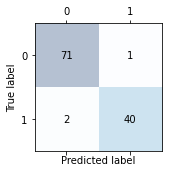

In [34]:
# 위 배열을 그림으로 나타내면
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

C:\Users\chang\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


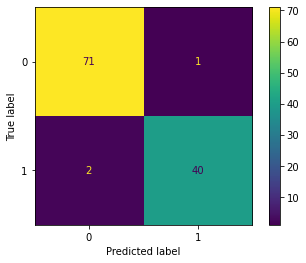

In [35]:
# plot_confusion_matrix를 이용해서도 나타낼 수 있다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe_svc, X_test, y_test)
plt.show()

C:\Users\chang\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


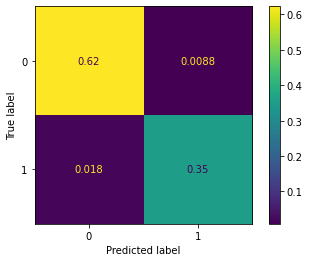

In [36]:
# 위의 두 함수는 normalize 매개변수를 통해 오차 행렬의 값을 정규화할 수 있다.
plot_confusion_matrix(pipe_svc, X_test, y_test, 
                      normalize='all')
plt.show()

### 6.5.2 분류 모델의 정밀도와 재현율 최적화

- 예측 오차(ERR)와 정확도(ACC) 모두 얼마나 많은 샘플을 잘못 분류했는지 일반적인 정보를 알려준다.
- 오차는 잘못된 예측의 합을 전체 예측 샘플 개수로 나눈 것이다.
- 정확도는 옳은 예측의 합을 전체 예측 샘플 개수로 나누어 계산한다.

    $ERR = $$\frac {FP+FN}{FP+FN+TP+TN}$  
    $ACC = $$\frac {TP+TN}{FP+FN+TP+TN} = 1 - ERR$
- 진짜 양성 비율 (TPR)과 거짓 양성 비율 (FPR)은 클래스 비율이 다른 경우 유용한 성능 지표이다.

    $FPR = \frac {FP}{N} = \frac{FP}{FP+TN}$  
    $TPR = \frac {TP}{P} = \frac{TP}{FN+TP}$  
예를 들어 종양 진단 문제에서는 환자가 적절한 치료를 받을 수 있도록 악성 종양을 감지하는 데 관심이 있다. 또 불필요하게 환자에게 걱정을 끼치지 않도록 음성 종양이 악성으로 분류되는 경우를 줄이는 것이 중요하다. FPR에 비해서 TPR은 전체 양성 샘플 중에서 올바르게 분류된 양성 샘플의 비율을 알려준다.  
  
정확도(PRE)와 재현율(REC) 성능 지표는 진짜 양성과 진짜 음성 샘플의 비율과 관련이 있다.  
        $PRE = \frac{TP}{TP + FP}$  
        $REC = TPR = \frac {TP}{P} = \frac {TP}{FN + TP}$  
PRE와 REC 최적화로 인한 장단점의 균형을 맞추기 위해 PRE와 REC를 조합한 F1-점수를 자주 사용한다.  
        $F1 = 2 \frac{PRE\times REC}{PRE+REC}$  
        

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


사이킷런에서 양성 클래스는 레이블이 1인 클래스이다.  
양성 레이블을 바꾸고 싶으면 make_scorer 함수를 사용하여 자신만의 함수를 만들 수 있다.  


In [38]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### 6.5.3 ROC 곡선 그리기

- ROC 그래프는 분류기의 임계 값을 바꾸어 가며 계산된 FPR과 TPR 점수를 기반으로 분류 모델을 선택하는 유용한 도구이다.
- ROC 그래프의 대각선은 랜덤 추측으로 해석할 수 있고 대각선 아래에 위치한 분류 모델은 랜덤 추측보다 나쁜 셈이다.
- 완벽한 분류기의 그래프는 TPR이 1이고 FPR이 0인 왼쪽 위 구석에 위치한다.
- ROC 곡선 아래 면적인 ROC AUC를 계산하여 분류 모델의 성능을 종합할 수 있다.


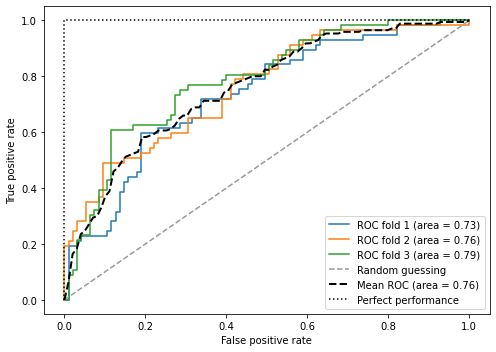

In [39]:
# 두 개의 특성을 추출하여 종양의 악성 여부를 예측하는 분류 모델의 ROC 곡선을 그려본다.
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

이전 코드에서 자주 보았던 사이킷런의 StratifiedKFold를 사용했다.  
각 반복에서 sklearn.metrics 모듈의 roc_curve 함수를 사용하여 파이프라인 안에 있는 LogisticRegression 모델의 ROC 값을 계산했다.  
또 사이파이의 interp 함수를 사용하여 곡선 아래 면적을 계산한다.  
만들어진 ROC 곡선을 보면 폴드에 따라 어느 정도 분산이 있음을 알 수 있다.  
평균 ROC AUC(0.76)는 완벽한 경우와 랜덤 추측 사이에 있다.

### 6.5.4 다중 분류의 성능 지표
- 사이킷런은 이런 평균 지표에 마크로와 마이크로 평균 방식을 구현하여 **OvA**방식을 사용하는 다중 분류로 확장한다.
- 마이크로 평균은 클래스별로 TP, TN, FP, FN을 계산한다.  
    $PRE_{micro} = \frac {TP_1 + ... + TP_k}{TP_1 + ... + TP_k + FP_1 + ... + FP_k}$
- 마크로 평균은 단순하게 클래스별 정밀도의 평균이다.  
    $PRE_{macro} = \frac {Pre_1 + ... + PRE_k}{k}$
- 마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용한다.
- 마크로 평균은 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가한다.
- 이 방식에서는 가장 빈도 높은 클래스 레이블의 성능이 중요하다.
---
- 사이킷런에서 이진 성능 지표로 다중 분류 모델을 평가하면 정규화 또는 가중치가 적용된 마크로 평균이 기본으로 적용된다.
- 가중치가 적용된 마크로 평균은 평균을 계산할 때 각 클래스 레이블의 샘플 개수를 가중하여 계산한다.
- 가중치가 적용된 마크로 평균은 레이블마다 샘플 개수가 다른 불균형한 클래스를 다룰 때 유용하다.
  
  사이킷런에서 가중치가 적용된 마크로 평균이 다중 분류 문제에서 기본값이지만 sklearn.metrics 모듈 아래에 있는 측정 함수들은 average 매개변수로 평균 계산 방식을 지정할 수 있다.

In [40]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

## 6.6 불균형한 클래스 다루기
- 클래스 불균형은 실전 데이터를 다룰 때 매우 자주 나타나는 문제이다.
- 한 개 또는 여러 개의 클래스 샘플이 데이터셋에 너무 많을 때이다.
- 이런 문제가 주로 나타나는 분야는 스팸 필터링, 부정 감지, 질병 차단 등이 있다.


212개의 악성 종양 / 357개의 양성 종양을 가진 유방암 데이터 셋에서 불균형한 데이터셋을 만들어보자.

In [41]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

이 코드에서 357개의 양성 종양 샘플 전체와 40개의 악성 종양 샘플을 연결하여 불균형이 심한 데이터셋을 만들었다.  
무조건 다수 클래스를 예측하는 모델은 거의 90%의 정확도를 달성할 것이다.

In [42]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

이런 데이터셋에 분류 모델을 훈련할 때 모델을 비교하기 위해 정확도를 사용하는 것보다 다른 지표를 활용하는 것이 좋다.  
애플리케이션에서 주요 관심 대상이 무엇인지에 따라 정밀도, 재현율, ROC 곡선 등을 사용할 수 있다.  
여기서는 재현율 지표를 선택해야한다. 
  
스팸 필터의 경우 햄 이메일이 너무 자주 스팸으로 처리되는 것을 원하지 않는다.  
여기서는 정밀도가 더 적절한 지표이다.  

---
머신 러닝 모델을 평가하는 것과 별개로 클래스 불균형은 모델이 훈련되는 동안 학습 알고리즘 자체에 영향을 미친다.  
머신 러닝 알고리즘이 일반적으로 훈련하는 동안 처리한 샘플에서 계산한 보상 또는 비용 함수의 합을 최적화한다.  
결정 규칙은 다수 클래스 쪽으로 편향되기 쉽다.  
즉, 알고리즘이 훈련 과정에서 비용을 최소화하거나 보상을 최대화하기 위해 데이터셋에서 가장 빈도가 높은 클래스의 예측을 최적화하는 모델을 학습한다.

---
모델을 훈련하는 동안 불균형한 클래스를 다루는 한 가지 방법은 소수 클래스에서 발생한 예측 오류에 큰 벌칙을 부여하는 것이다.  
사이킷런에서는 대부분의 분류기에 구현된 class_weight 매개변수를 class_weight='balanced'로 설정해서 이런 벌칙을 편리하게 조정할 수 있다.  

---
불균형한 클래스를 다루는 데 널리 사용하는 다른 전략은 소수 클래스의 샘플을 늘리거나 다수 클래스의 샘플을 줄이거나 인공적으로 훈련 샘플을 생성하는 것이다.  
사이킷런 라이브러리는 데이터셋에서 중복을 허용한 샘플 추출 방식으로 소수 클래스의 샘플을 늘리는데 사용할 수 있는 resample 함수를 제공한다.  


In [43]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링하기 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링하기 후 클래스 1의 샘플 개수: 357


In [44]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [45]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

비슷하게 데이터셋에서 다수 클래스의 훈련 샘플을 삭제하여 다운샘플링할 수 있다. resample 함수를 사용하여 다운샘플링을 수행하려면 이전 예에서 클래스 레이블 1과 0을 서로 바꾸면 된다.

## 6.7 요약

- 파이프라인을 사용하여 모델 선택과 평가를 위한 핵심 기법인 k-겹 교차 검증을 수행했다.
- k-겹 교차 검증으로 학습 곡선과 검증 곡선을 그려 과대적합과 과소적합 같은 머신 러닝 모델에서 흔히 나타나는 문제를 분석했다.
- 모델을 세부 튜닝하기 위해 그리드 서치를 사용했다.
- 오차 행렬과 다양한 성능 지표를 사용하여 해당 묹에게 맞는 모델의 성능을 평가하고 최적화했다.
- 실전 애플리케이션에서 흔히 발생하는 불균형한 데이터를 다루기 위한 여러 방법을 설명했다.